# load dataset list

In [10]:
from cellpose import utils, io, models
# if you cant change kernel to `cellpose`, ctrl+shift+p -> python: select interpreter -> select in folder:  C:\Users\ll357\AppData\Local\anaconda3\envs\cellpose\python.exe -> now you can select correct kernel

import pandas as pd
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['axes.titlesize'] = 5

import os
import glob
import time
from datetime import datetime
from IPython.display import clear_output
import logging

In [11]:
def show_segmentation_LL(fig, img, maski, flowi, channels=[0,0], file_name=None):
    """ plot segmentation results (like on website)
    
    Can save each panel of figure with file_name option. Use channels option if
    img input is not an RGB image with 3 channels.
    LL: changed subplot arrangement for wide subplots. turned off saving
    
    Parameters
    -------------

    fig: matplotlib.pyplot.figure
        figure in which to make plot

    img: 2D or 3D array
        image input into cellpose

    maski: int, 2D array
        for image k, masks[k] output from Cellpose.eval, where 0=NO masks; 1,2,...=mask labels

    flowi: int, 2D array 
        for image k, flows[k][0] output from Cellpose.eval (RGB of flows)

    channels: list of int (optional, default [0,0])
        channels used to run Cellpose, no need to use if image is RGB

    file_name: str (optional, default None)
        file name of image, if file_name is not None, figure panels are saved
        
    seg_norm: bool (optional, default False)
        improve cell visibility under labels
        

    """
    from cellpose.plot import image_to_rgb, mask_overlay

    ax = fig.add_subplot(4,1,1)
    img0 = img.copy()

    if img0.shape[0] < 4:
        img0 = np.transpose(img0, (1,2,0))
    if img0.shape[-1] < 3 or img0.ndim < 3:
        img0 = image_to_rgb(img0, channels=channels)
    else:
        if img0.max()<=50.0:
            img0 = np.uint8(np.clip(img0*255, 0, 1))
    ax.imshow(img0)
    ax.set_title('original image: stim resp dfof, gaussian filtered')
    ax.axis('off')

    outlines = utils.masks_to_outlines(maski)

    overlay = mask_overlay(img0, maski)

    ax = fig.add_subplot(4,1,2)
    outX, outY = np.nonzero(outlines)
    imgout= img0.copy()
    imgout[outX, outY] = np.array([255,0,0]) # pure red

    ax.imshow(imgout)
    ax.set_title('predicted outlines')
    ax.axis('off')

    ax = fig.add_subplot(4,1,3)
    ax.imshow(overlay)
    ax.set_title('predicted masks')
    ax.axis('off')

    ax = fig.add_subplot(4,1,4)
    ax.imshow(flowi)
    ax.set_title('predicted cell pose')
    ax.axis('off')

    # if file_name is not None:
    #     save_path = os.path.splitext(file_name)[0]
    #     io.imsave(save_path + '_overlay.jpg', overlay)
    #     io.imsave(save_path + '_outlines.jpg', imgout)
    #     io.imsave(save_path + '_flows.jpg', flowi)

In [12]:
dir_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = dir_inter + 'adp_dataset_master.xlsx'
data_info = pd.read_excel(dir_file)
data_info.tail()

mouse    date area  depth  num  cellpose_seg manual_seg  \
173   1381  240226   V1    NaN  003           1.0        NaN   
174   1392  240225   V1    NaN  002           1.0        NaN   
175   1392  240225   V1    NaN  003           1.0        NaN   
176   1392  240228   V1    NaN  002           NaN        NaN   
177   1392  240228   V1    NaN  003           NaN        NaN   

                        paradigm gcamp    time  AWS note  
173  grating_8ori_2isi_multisess    6s     NaN  NaN  NaN  
174       grating_2ori_multisess    6s  1122.0  NaN  NaN  
175       grating_2ori_multisess    6s  1308.0  NaN  NaN  
176  grating_8ori_2isi_multisess    6s     NaN  NaN  NaN  
177  grating_8ori_2isi_multisess    6s     NaN  NaN  NaN

In [13]:
## pymatbridge fails silently. TODO: fix logging

# from pymatbridge import Matlab
# mlab = Matlab(log=True)
# mlab.start()

# dir_func = r'C:\Users\GlickfeldLab\Documents\test\inter\scripts\adp_function\get_data_reg_cellpose_tif.m'.replace('\\', '/')
# res = mlab.run_func(dir_func, {'arg_mouse': df_bun.iloc[0].mouse, 'arg_date': df_bun.iloc[0].date})
# # print(res['result'].shape)
# res

# mlab.stop()

# batch cellpose
run cellpose in batch with matlab: 
sleep until cellpose tif is generated

## multi-session cellpose

In [14]:
meta = data_info[(data_info.area == 'V1')
                #  & (data_info.paradigm == 'grating_8ori_2isi_multisess') 
                 & (data_info.date == 240228)
                 ]
meta

mouse    date area  depth  num  cellpose_seg manual_seg  \
176   1392  240228   V1    NaN  002           NaN        NaN   
177   1392  240228   V1    NaN  003           NaN        NaN   

                        paradigm gcamp  time  AWS note  
176  grating_8ori_2isi_multisess    6s   NaN  NaN  NaN  
177  grating_8ori_2isi_multisess    6s   NaN  NaN  NaN

In [15]:
# multisess cellpose

data_dates = meta.date.unique()
nset = len(data_dates) # multisess 1 date = 1 dataset, already merged tiff of each session in matlab

for i in np.arange(nset):

    clear_output(wait=True)
    print('set ', i+1, 'of', nset)
    
    mouse = meta.loc[meta.date == data_dates[i]].iloc[0].mouse.astype(str)
    imouse = 'i' + mouse
    date = meta.loc[meta.date == data_dates[i]].iloc[0].date.astype(str)
    # irun = '00' + df_stim.iloc[i].num.astype(int).astype(str)
    # print(imouse, date, irun)

    #####################################
    
    ## go to analysis directory of multisess tif folder (one level above sess folder)
    dir_analysis = r'Z:\All_Staff\home\lan\Analysis\2P'.replace('\\', '/')
    dir_run = '' # do not go into sess folder
    date_imouse = date + '_' + imouse
    dir_full = os.path.join(dir_analysis, date_imouse).replace('\\', '/')
    # dir_run = 'runs-004'
    # date_imouse_run = date + '_' + imouse + '_' + dir_run
    # dir_full = os.path.join(dir_analysis, date_imouse, date_imouse_run).replace('\\', '/')
    try:
        os.chdir(dir_full)
    except:
        print('directory not found, creating...')
        os.mkdir(dir_full)
        os.chdir(dir_full)
    print(os.getcwd())
    
    ## check if cellpose time course exists. TODO: fix detection of sess TC
    cellpose_done = False
    TCs_cellpose = glob.glob(dir_full + '/**/*_TCs_cellpose.mat', recursive=True)
    if len(TCs_cellpose) >= 2: # at least 2 sess has time course = multisess done
        cellpose_done = True
        print(TCs_cellpose)
        print('cellpose time course exists, skip to next set')
        continue

    ## load tif after waiting for matlab to create tif
    files = ['cellpose_stim_resp_gauss.tif']
    while True:
        try:
            img = io.imread(files[0])
            print('set ', i+1, 'of', nset)
            print(imouse, date)
            print('found tif')
            break
        except:
            print('set ', i+1, 'of', nset)
            print(imouse, date)
            print('waiting for tif')
            time.sleep(60)
            clear_output(wait=True)

    img = io.imread(files[-1])
    assert img.shape == (264, 796) # confirm image shape: 30 frame/sec

    plt.figure(figsize=(2,2))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    # plt.savefig(dir_full + '/' + files[-1].replace('.tif', '.png'))

    #####################################

    ## run cellpose
    model = models.Cellpose(gpu=True, model_type='cyto') # enabled gpu, cudatoolkit=11.3
    channels = [[0,0]] # must be a list of lists for multiple images
    diameter = 20 # can be a list for multiple images
    flow_threshold = -1 # 0.4 # reset to default 0.4. previously -1
    cellprob_threshold = -1 # 0.0 # reset to default. previously -1

    for chan, filename in zip(channels, files):
        img = io.imread(filename)
        masks, flows, styles, diams = model.eval(img, \
            diameter=None, channels=chan, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)
        io.masks_flows_to_seg(img, masks, flows, diams, filename, chan) # save npy
    ncell = np.max(np.unique(masks)) # check the number of cells
    print(f'found {ncell} cells')

    assert masks.shape == (264, 796)
    sio.savemat('cellpose_mask.mat', mdict={'cellpose_mask': masks}) # save cellpose mask to mat

    fig = plt.figure(figsize=(12,5))
    show_segmentation_LL(fig, img, masks, flows[0], channels=chan)
    plt.tight_layout()
    plt.show()
    fig.savefig("cellpose_mask.pdf", bbox_inches='tight') # handle is fig

    #####################################

set  1 of 1
i1392 240228
waiting for tif


## single-session cellpose

In [4]:
meta = data_info[(data_info.paradigm == 'grating') & ((data_info.area == 'LM') | (data_info.area == 'LI'))]
meta.area.value_counts()

LM    23
LI    22
Name: area, dtype: int64

set  45 of 45
i1374 230323 003
found tif


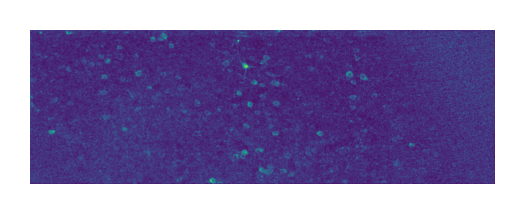

number of cells detected: 65


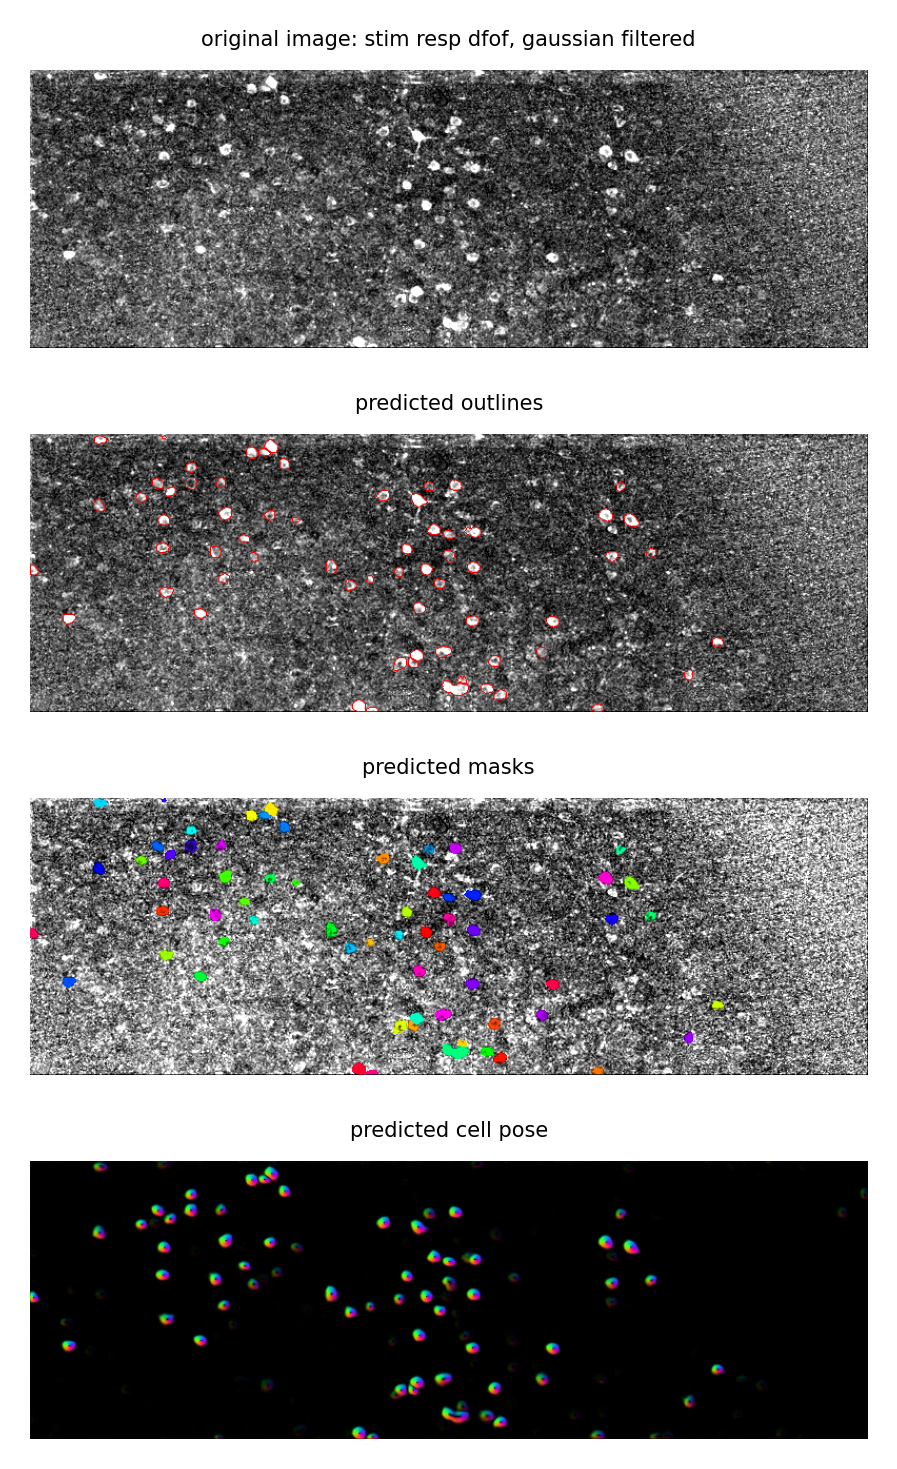

In [10]:
# single sess cellpose

## set up logging
plt.set_loglevel(level='warning') # turn off matplotlib debug logging
logging.basicConfig(filename='C:/Users/ll357/Documents/inter/data/cellpose.log', level=logging.DEBUG)
logging.info(str(datetime.now()))

nset = meta.shape[0]
for i in np.arange(nset):
    
    clear_output(wait=True)
    print('set ', i+1, 'of', nset)
    mouse = meta.iloc[i].mouse.astype(str)
    imouse = 'i' + mouse
    date = meta.iloc[i].date.astype(str)
    irun = '00' + meta.iloc[i].num.astype(int).astype(str)
    print(imouse, date, irun)
    logging.info(f'cellpose segmenting: mouse {imouse}, date {date}, run-{irun}')

    #####################################

    ## go to analysis directory
    dir_analysis = r'Z:\All_Staff\home\lan\Analysis\2P'.replace('\\', '/')
    date_imouse = date + '_' + imouse
    dir_run = date_imouse + '_runs-' + irun
    dir_full = os.path.join(dir_analysis, date_imouse, dir_run).replace('\\', '/')
    try:
        os.chdir(dir_full)
    except:
        print('directory not found, creating...')
        os.mkdir(dir_full)
        os.chdir(dir_full)

    ## check if cellpose time course exists
    TC_done = False
    for filename in os.listdir(dir_full):
        if ('TCs_cellpose.mat' in filename) or ('TCs_addfake.mat' in filename):
            TC_done = True
    if TC_done:
        print('cellpose or manual time course exists, skip to next set')
        logging.info(f'cellpose or manual time course exists, skip to next set')
        continue

    ## load tif after waiting for matlab to create tif
    files = ['cellpose_stim_resp_gauss.tif']
    logging.info(f'waiting for tif')
    while True:
        try:
            img = io.imread(files[0])
            print('set ', i+1, 'of', nset)
            print(imouse, date, irun)
            print('found tif')
            logging.info(f'found tif')
            break
        except:
            print('set ', i+1, 'of', nset)
            print(imouse, date, irun)
            print('waiting for tif')
            time.sleep(60)
            clear_output(wait=True)

    img = io.imread(files[-1])
    assert img.shape == (264, 796) # confirm image shape: 30 frame/sec
    plt.figure(figsize=(2,2))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    # plt.savefig(dir_full + '/' + files[-1].replace('.tif', '.png'))
    
    #####################################

    ## run cellpose
    model = models.Cellpose(gpu=True, model_type='cyto') # enabled gpu, cudatoolkit=11.3
    channels = [[0,0]] # must be a list of lists for multiple images
    diameter = 20 # can be a list for multiple images
    flow_threshold = -1 # default 0.4. previously -1
    cellprob_threshold = -1 # default 0. previously -1

    for chan, filename in zip(channels, files):
        img = io.imread(filename)
        masks, flows, styles, diams = model.eval(img, \
            diameter=None, channels=chan, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)
        io.masks_flows_to_seg(img, masks, flows, diams, filename, chan) # save npy

    ncell = np.max(np.unique(masks)) # check the number of cells
    print(f'number of cells detected: {ncell}')
    logging.info(f'number of cells detected: {ncell} at time {datetime.now()}. for mouse {imouse}, date {date}, run-{irun}')
    if ncell < 10:
        logging.warning('likely no cell detected!!')

    assert masks.shape == (264, 796)
    sio.savemat('cellpose_mask.mat', mdict={'cellpose_mask': masks}) # save cellpose mask to mat

    fig = plt.figure(figsize=(12,5))
    show_segmentation_LL(fig, img, masks, flows[0], channels=chan)
    plt.tight_layout()
    plt.show()
    fig.savefig("cellpose_mask.pdf", bbox_inches='tight') # handle is fig

### save npy to mat
for hand-select cellpose LI data

In [8]:
meta = data_info[(data_info.paradigm == 'grating') & (data_info.area == 'LI')]
meta = meta[meta.manual_seg != 'TODO'] # there are 2 TODOs in LI data
meta.area.value_counts()

LI    20
Name: area, dtype: int64

In [12]:
meta

mouse    date area  depth  num  cellpose_seg manual_seg paradigm gcamp  \
2     1323  200723   LI  200.0    3           NaN       True  grating    6s   
7     1322  200806   LI  200.0    3           NaN       True  grating    6s   
11    1328  201202   LI  200.0    3           NaN       True  grating    6s   
12    1328  201202   LI  150.0    4           NaN       True  grating    6s   
16    1329  210113   LI  200.0    4           NaN    RECHECK  grating    6s   
17    1329  210113   LI  150.0    6           NaN    RECHECK  grating    6s   
22    1337  210203   LI  200.0    3           NaN    RECHECK  grating    6s   
23    1337  210203   LI  150.0    4           NaN    RECHECK  grating    6s   
47    1339  210930   LI  200.0    2           NaN    RECHECK  grating    6s   
48    1339  210930   LI  150.0    3           NaN    RECHECK  grating    6s   
54    1350  211028   LI  200.0    2           NaN    RECHECK  grating    6s   
55    1350  211028   LI  150.0    3           NaN    RECHECK  grating    6s   
98    1380  230110   LI  200.0    2           1.0    RECHECK  grating    6s   
99    1380  230110   LI  150.0    3           1.0    RECHECK  grating    6s   
122   1373  230228   LI  200.0    2           1.0        NaN  grating    6s   
123   1373  230228   LI  150.0    3           1.0        NaN  grating    6s   
129   1381  230309   LI  200.0    2           1.0    RECHECK  grating    6s   
130   1381  230309   LI  150.0    3           1.0        NaN  grating    6s   
133   1374  230323   LI  200.0    2           1.0        NaN  grating    6s   
134   1374  230323   LI  150.0    3           1.0        NaN  grating    6s   

     AWS                                              note  
2    1.0                                               NaN  
7    1.0                                               NaN  
11   1.0                                               NaN  
12   1.0                                               NaN  
16   NaN  terrible timecourse by cellpose, must manual seg  
17   NaN                                               NaN  
22   NaN                                               NaN  
23   NaN                                               NaN  
47   NaN                                               NaN  
48   NaN                                               NaN  
54   NaN                                               NaN  
55   NaN                                               NaN  
98   NaN                       consider manual seg as well  
99   NaN                                               NaN  
122  NaN                                               NaN  
123  NaN                                               NaN  
129  NaN                         can manual seg more cells  
130  NaN             todo: get rid of false cells on edge   
133  NaN          likely not LI. Agreed by 2p imaging note  
134  NaN                                               NaN

set  1 of 20
i1323 200723 003
Z:/All_Staff/home/lan/Analysis/2P/200723_i1323/200723_i1323_runs-003
no cellpose hand-select mask found, skip to next set
set  2 of 20
i1322 200806 003
Z:/All_Staff/home/lan/Analysis/2P/200806_i1322/200806_i1322_runs-003
no cellpose hand-select mask found, skip to next set
set  3 of 20
i1328 201202 003
Z:/All_Staff/home/lan/Analysis/2P/201202_i1328/201202_i1328_runs-003
no cellpose hand-select mask found, skip to next set
set  4 of 20
i1328 201202 004
Z:/All_Staff/home/lan/Analysis/2P/201202_i1328/201202_i1328_runs-004
no cellpose hand-select mask found, skip to next set
set  5 of 20
i1329 210113 004
Z:/All_Staff/home/lan/Analysis/2P/210113_i1329/210113_i1329_runs-004
set  6 of 20
i1329 210113 006
Z:/All_Staff/home/lan/Analysis/2P/210113_i1329/210113_i1329_runs-006
set  7 of 20
i1337 210203 003
Z:/All_Staff/home/lan/Analysis/2P/210203_i1337/210203_i1337_runs-003
set  8 of 20
i1337 210203 004
Z:/All_Staff/home/lan/Analysis/2P/210203_i1337/210203_i1337_runs-

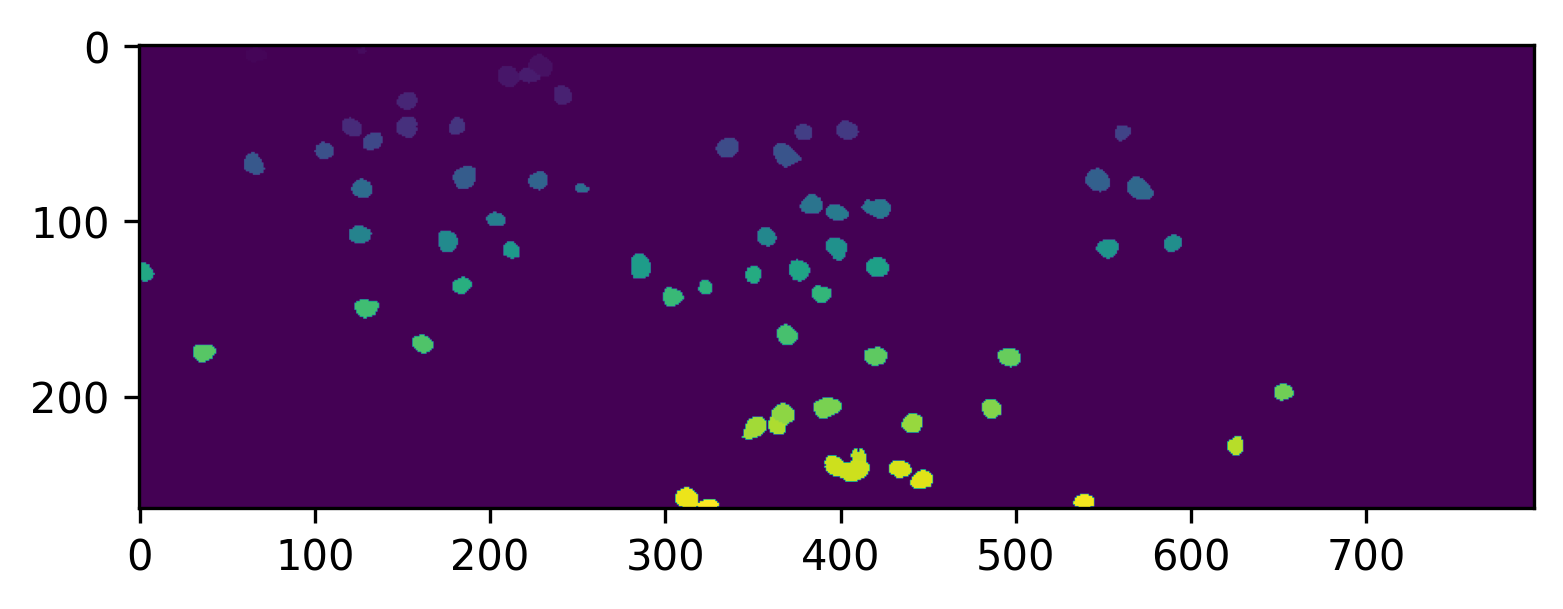

In [14]:
nset = meta.shape[0]
for i in np.arange(nset):
    
    # clear_output(wait=True)
    print('set ', i+1, 'of', nset)
    mouse = meta.iloc[i].mouse.astype(str)
    imouse = 'i' + mouse
    date = meta.iloc[i].date.astype(str)
    irun = '00' + meta.iloc[i].num.astype(int).astype(str)
    print(imouse, date, irun)

    #####################################

    ## go to analysis directory
    dir_analysis = r'Z:\All_Staff\home\lan\Analysis\2P'.replace('\\', '/')
    date_imouse = date + '_' + imouse
    dir_run = date_imouse + '_runs-' + irun
    dir_full = os.path.join(dir_analysis, date_imouse, dir_run).replace('\\', '/')
    # try:
    os.chdir(dir_full)
    # except:
    #     print('directory not found, creating...')
    #     os.mkdir(dir_full)
    #     os.chdir(dir_full)

    # ## check if cellpose time course exists
    # TC_done = False
    # for filename in os.listdir(dir_full):
    #     if ('TCs_cellpose.mat' in filename) or ('TCs_addfake.mat' in filename):
    #         TC_done = True
    # if TC_done:
    #     print('cellpose or manual time course exists, skip to next set')
    #     logging.info(f'cellpose or manual time course exists, skip to next set')
    #     continue

    print(dir_full)
    # break
    # dir_full = r'Z:\All_Staff\home\lan\Analysis\2P\210113_i1329\210113_i1329_runs-006'.replace('\\', '/')
    npy_list = [fn for fn in os.listdir(dir_full) if fn.endswith('.npy')]
    npy_list = [fn for fn in npy_list if 'v1' not in fn] # drop item if contains 'v1', which is cellpose version 1, auto seg. bad for LI data
    if len(npy_list) == 0:
        print('no cellpose hand-select mask found, skip to next set')
        continue
    assert len(npy_list) == 1

    cellpose_npy = npy_list[0]
    npy = np.load(os.path.join(dir_full, cellpose_npy), allow_pickle=True)
    # npy.item().keys()
    # npy.item()['masks'].shape, npy.item()['ismanual']
    plt.imshow(npy.item()['masks'])

    # save as mat
    masks = npy.item()['masks']
    assert masks.shape == (264, 796)
    sio.savemat(os.path.join(dir_full, 'cellpose_mask_v2.mat'), mdict={'cellpose_mask': masks}) # save cellpose mask to mat
    # break

## compare manual seg

set  1 of 1
i1375 230103 002
Z:\All_Staff\home\lan\Analysis\2P\230103_i1375
set  1 of 1
i1375 230103
found tif


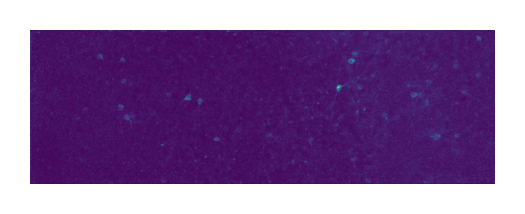

c:\Users\ll357\Anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ll357\Anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


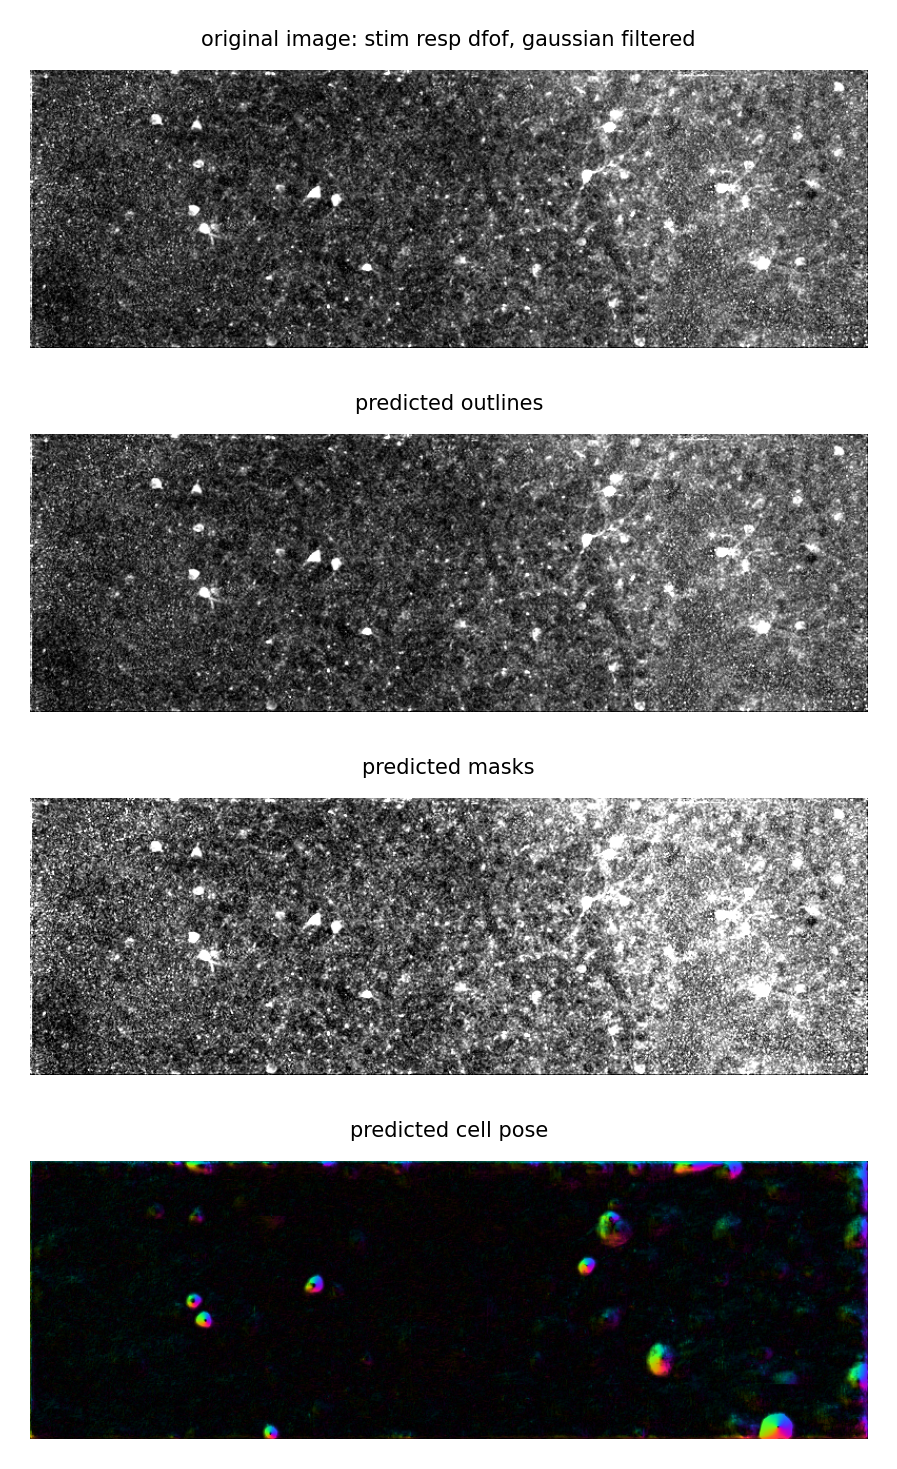

In [ ]:
    # ## check if manual segmentation exists
    # manual_done = False
    # for filename in os.listdir(dir_full):
    #     if 'TCs_addfake' in filename:
    #         print('manual segmentation exists, now compare with cellpose')
    #         manual_done = True
    
    # ## compare cellpose with manual segmentation
    # if manual_done:

    #     file_name = date_imouse + '_runs-' + irun + '_mask_cell_addfake.mat'
    #     manual_mask = sio.loadmat(file_name)
    #     manual_mask = manual_mask['mask_cell']
    #     assert manual_mask.shape == (264, 796)

    #     cellpose_mask_binary = masks.copy()
    #     cellpose_mask_binary[cellpose_mask_binary > 0] = 1
    #     manual_mask_binary = manual_mask.copy()
    #     manual_mask_binary[manual_mask_binary > 0] = 1

    #     plt.figure(figsize=(20, 10))
    #     plt.imshow(cellpose_mask_binary, cmap='Reds', alpha=0.5)
    #     plt.imshow(manual_mask_binary, cmap='Blues', alpha=0.5)
    #     plt.title('cellpose red, manual blue', fontsize=15)
    #     plt.tight_layout()
    #     plt.savefig("cellpose_compare_manual_mask.pdf", bbox_inches='tight')